# 15_오차역전파
## - 오차역전파 공식을 이용한 MNIST (필기체숫자) 인식 - 

=> MNIST
- MNIST(Modified National Institute of Standards and Texhnology)는 손으로 직접쓴 숫자(필기체 숫자)들로 이루어진 데이터 셋(Data Set)이며,
- 우리가 새로운 프로그래밍 언어를 배울 때 'Hello, World'를 출력하는 것처럼, MNIST는 딥러닝을 배울 때 반드시 거쳐야 하는 'Hello, Wordl' 같은 존재임.
- MNIST는 0부터 9까지의 숫자 이미지로 구성되며, 60000개의 트레이닝 데이터와 10000개의 테스트 데이터로 이루어져 있음.

MNIST - 구조 (1)
- => mnist_train.csv
- mnist_train.csv 파일에는 학습에 이용될 수 있도록 정답(lable)이 있는 총 60000개의 데이터 존재함. 1개의 데이터는 785개의 숫자가 콤마(,)로 분리 되어 있는데, 정답을 나타내는 1개의 숫자와 실제 필기체 숫자 이미지를 나타내는 784개의 숫자로 구성되어 잇음.

- => mnist_test.csv
- mnist_test.csv 파일에는 총 10000개의 데이터가 있으며, 학습을 마친 후에 구현된 딥러닝 아키텍처가 얼마나 잘 작동하는지 테스트 하기 위해 사용됨. 테스트 데이터 또한 정답(lable)이 포함된 785 개의 숫자로 되어 있음.

MNIST - 구조 (2)

In [37]:
# MNIST 가져오기 (numpy.loadtxt 활용)
# training data
import numpy as np

training_data = np.loadtxt('mnist_train.csv', delimiter = ',', dtype = np.float32)
test_data = np.loadtxt('mnist_test.csv', delimiter = ',', dtype = np.float32)

print("training_data.shape = ", training_data.shape, "test_data.shape = ", test_data.shape)

training_data.shape =  (60000, 785) test_data.shape =  (10000, 785)


MNIST - 구조 (3)

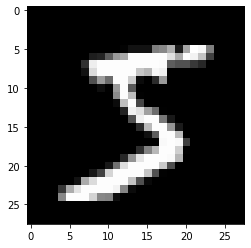

In [38]:
# training_data 이미지 표현
import matplotlib.pyplot as plt

img = training_data[0][1:].reshape(28, 28)

plt.imshow(img, cmap = 'gray')
plt.show()

NeuralNetwork calss - MNIST(필기체 숫자)인식 클래스

- external function
- def sigmoid(x):            # 0 또는 1을 출력하기 위한 sigmoid 함수
-    return 1/(1+np.exp(-x)) # numerical derivative 함수가 없는 것에 유의

- NeuralNetwork class
- from datetime import datetime # datetime.now()를 이용하여 학습 경과 시간 측정
- class NeuralNetwork:
-     def __init__(self, i_nodes, h_nodes, o_nodes, learning_rate) # 가중치/바이어스/각층 출력값/학습율 초기화
-     def feed_val(self) # feed forward 이용하여 손실함수 값 계산
-     def loss_val(self) # 손실함수 값 계산(외부 출력을 위해 사용됨)
-     def train(self, input_data, target_data) # 오차역전파 공식을 이용하여 가중치/바이어스 업데이트
-     def predict(self, input_data) # 입력 데이터에 대해 미래 값 예측
-     def accuracy(self, test_data) # 신경망 기반의 딥러닝 아키텍처 정확도 측정

- usage
- nn = NeuralNetwork(784, 100, 10, 0.3) # 입력노드 784개, 은닉노드 100개, 출력노드 10개, 학습률 0.3 객체 생성
- for i in range(epochs): # 학습 반복횟수
-    for step in range(60000): # 60000개의 training data 전체를 이용하여 학습 진행
-         input_data / target_data # one-hot encoding을 위한 데이터 정규화 작업 수행
-         nn.train(input_data, target_data) # training data를 이용하여 학습 진행

구현코드 - MNIST(필기체 숫자 인식)

In [39]:
# [1] external function (sigmoid)
import numpy as np
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [46]:
# [2] NeuralNetwork(__init__)
from datetime import datetime # datetime.now()를 이용하여 학습 경과 시간 측정
class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        self.__input_nodes = input_nodes
        self.__hidden_nodes = hidden_nodes
        self.__output_nodes = output_nodes
        
        # 은닉층 가중치 W2 = (784 X 100) Xavier/He 방법으로 self.W2 가중치 초기화
        self.__W2 = np.random.randn(self.__input_nodes, self.__hidden_nodes) / np.sqrt(self.__input_nodes / 2)
        self.__b2 = np.random.rand(self.__hidden_nodes)
        
        # 출력층 가중치는 W3 = (100 X 10) Xavier/He 방법으로 self.W3 가중치 초기화
        self.__W3 = np.random.randn(self.__hidden_nodes, self.__output_nodes) / np.sqrt(self.__hidden_nodes / 2)
        self.__b3 = np.random.rand(self.__output_nodes)
        
        # 출력층 선형회귀 값 Z3, 출력값 A3 정의 (모두 행렬로 표시)
        self.Z3 = np.zeros([1, self.__output_nodes])
        self.A3 = np.zeros([1, self.__output_nodes])
        
        # 은닉층 선형회귀 값 Z2, 출력값 A2 정의 (모두 행렬로 표시)
        self.Z2 = np.zeros([1, self.__hidden_nodes])
        self.A2 = np.zeros([1, self.__hidden_nodes])
        
        # 입력층 선형회귀 값 Z1, 출력값 A1 정의 (모두 행렬로 표시)
        self.Z1 = np.zeros([1, self.__input_nodes])
        self.A1 = np.zeros([1, self.__input_nodes])
        
        # 학습률 learning_rate 초기화
        self.__learning_rate = learning_rate
# [2] NeuralNetwork(feed_forward, loss_val)
    def feed_forward(self):

        delta = 1e-7 # log 무한대 발산 방지

        # 입력층 선형회귀 값 Z1, 출력값 A1 계산
        self.Z1 = self.__input_data
        self.A1 = self.__input_data

        # 은닉층 선형회귀 값 Z2, 출력값 A2 계산
        self.Z2 = np.dot(self.A1, self.__W2) + self.__b2
        self.A2 = sigmoid(self.Z2)

        return -np.sum(self.__target_data * np.log(self.A3 + delta) + (1 - self.__target_data)) * np.log((1 - self.A3) + delta)
    def loss_val(self):
        
        delta = 1e-7 # log 무한대 발산 방지
        # 입력층 선형회귀 값 Z1, 출력값 A1 계산
        self.Z1 = self.__input_data
        self.A1 = self.__input_data
        
        # 은닉층 선형회귀 값 Z2, 출력값 A2 계산
        self.Z2 = np.dot(self.A1, self.__W2) + self.__b2
        self.A2 = sigmoid(self.Z2)
        
        # 출력층 선형회귀 값 Z3, 출력값 A3 계산
        self.Z3 = np.dot(self.A2, self.__W3) + self.__b3
        self.A3 = sigmoid(self.Z3)
        
        return -np.sum(self.__target_data * np.log(self.A3 + delta) + (1 - self.__target_data)) * np.log((1 - self.A3) + delta)
# [2] NeuralNetwork(train, predict)
    def train(self, input_data, target_data): # input_data : 784개, target_data : 10개
        
        self.__target_data = target_data
        self.__input_data = input_data
        
        # 먼저 feed forward 를 통해서 최종 출력값과 이를 바탕으로 현재의 에러 값 계산
        loss_val = self.feed_forward()
        
        # 출력층 loss인 loss_3 구한
        loss_3 = (self.A3 - self.__target_data) * self.A3 * (1 - self.A3)
        
        # 출력층 가중치 W3, 출력층 바이어스 b3 업데이트
        self.__W3 = self.__W3 - self.__learning_rate * np.dot(self.A2.T, loss_3)
        
        self.__b3 = self.__b3 - self.__learning_rate * loss_3
        
        # 은닉층 loss 인 loss_2 구함
        loss_2 = np.dot(loss_3, self.__W3.T) * self.A2 * (1 - self.A2)
        
        # 은닉층 가중치 W2, 은닉층 바이어스 b2 업데이트
        self.__W2 = self.__W2 - self.__learning_rate * np.dot(self.A1.T, loss_2)
        
        self.__b2 = self.__b2 - self.__learning_rate * loss_2
        
    def predict(self, input_data): # input_data는 행렬로 입력됨 즉, (1, 784) shape 을 가짐
        
        Z2 = np.dot(input_data, self.__W2) + self.__b2
        A2 = sigmoid(Z2)
        
        Z3 = np.dot(A2, self.__W3) + self.__b3
        A3 = sigmoid(Z3)
        
        predicted_num = np.argmax(A3)
        
        return predicted_num
    
# [2] NeuralNetwork (accuracy)
    # 정확도 측정함수
    def accuracy(self, test_data): # MNIST test_data(10000 X 785)
        matched_list = []
        not_matched_list = []
        
        for index in range(len(test_data)):
            
            label = int(test_data[index, 0])
            
            # one-hot encoding을 위한 데이터 정규화 (data normalize)
            data = (test_data[index, 1:] / 255.0 * 0.99) + 0.01
            
            # predict 를 위해서 vector 을 matrix 로 변환하여 인수로 넘겨줌
            predicted_num = self.predict(np.array(data, ndmin = 2))
            
            if label == predicted_num:
                matched_list.append(index)
            else:
                not_matched_list.append(index)
                
        print("Current Accuracy = ", 100 * (len(matched_list) / (len(test_data))), " %")
        
        return matched_list, not_matched_list

검증코드 - MNIST (필기체 숫자 인식)

In [47]:
# [3] usage (data feeding)
# 0 ~ 9 숫자 이미지가 784개의 숫자 (28 X 28)로 구성되어 있는 training data 읽어옴
training_data = np.loadtxt('mnist_train.csv', delimiter = ',', dtype = np.float32)

# 0 ~ 9 숫자 이미지가 784개의 숫자 (28 X 28)로 구성되어 있는 test data 읽어옴
test_data = np.loadtxt('mnist_test.csv', delimiter = ',', dtype = np.float32)

In [48]:
print("training_data.shpae = ", training_data.shape, ", test_data.shape = ", test_data.shape)

training_data.shpae =  (60000, 785) , test_data.shape =  (10000, 785)


In [49]:
print("trainig_data[0, 0] = ", training_data[0, 0], ", test_data[0, 0] = ", test_data[0, 0])

print("len(training_data[0]) = ", len(training_data[0]), ", len(test_data[0]) = ", len(test_data[0]))

trainig_data[0, 0] =  5.0 , test_data[0, 0] =  7.0
len(training_data[0]) =  785 , len(test_data[0]) =  785


In [50]:
# [3] usage (learning process)
input_nodes = 784
hidden_nodes = 100
output_nodes = 10
learning_rate = 0.3
epochs = 1

nn = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

start_time = datetime.now()

for i in range(epochs):
    
    for step in range(len(training_data)): # train
        
        # input_data, target_data normalize
        target_data = np.zeros(output_nodes) + 0.01
        target_data[int(training_data[step, 0])] = 0.99
        
        input_data = ((training_data[step, 1:] / 255.0) * 0.99) + 0.01
        
        nn.train(np.array(input_data, ndmin = 2), np.array(target_data, ndmin = 2))
        
        if step % 400 == 0:
            print("step = ", step, ", loss_val = ", nn.loss_val())
            
end_time = datetime.now()
print("\nelapsed time = ", end_time - start_time)

step =  0 , loss_val =  [[ 4.90576604  9.65227933 12.15921833  5.90610897 12.3012935   8.46234172
   4.47295817 16.98050876 14.89893371 11.87136148]]


C:\Users\서경덕\AppData\Local\Temp/ipykernel_15000/1038810490.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


step =  400 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07]]
step =  800 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07]]
step =  1200 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07]]
step =  1600 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07]]
step =  2000 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07]]
step =  2400 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.4

step =  18400 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07]]
step =  18800 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07]]
step =  19200 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07]]
step =  19600 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07]]
step =  20000 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07]]
step =  20400 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288

step =  36800 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07]]
step =  37200 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07]]
step =  37600 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07]]
step =  38000 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07]]
step =  38400 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07]]
step =  38800 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288

step =  54800 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07]]
step =  55200 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07]]
step =  55600 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07]]
step =  56000 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07]]
step =  56400 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07 8.48754288e-07 8.48754288e-07
  8.48754288e-07 8.48754288e-07]]
step =  56800 , loss_val =  [[8.48754288e-07 8.48754288e-07 8.48754288

In [51]:
nn.accuracy(test_data) # epochs == 1인 경우

C:\Users\서경덕\AppData\Local\Temp/ipykernel_15000/1038810490.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Current Accuracy =  9.8  %


([3,
  10,
  13,
  25,
  28,
  55,
  69,
  71,
  101,
  126,
  136,
  148,
  157,
  183,
  188,
  192,
  194,
  215,
  246,
  269,
  271,
  294,
  296,
  297,
  305,
  311,
  312,
  324,
  327,
  346,
  365,
  372,
  380,
  407,
  424,
  440,
  441,
  443,
  459,
  485,
  490,
  498,
  525,
  545,
  546,
  552,
  561,
  564,
  567,
  581,
  586,
  592,
  597,
  608,
  611,
  620,
  642,
  644,
  656,
  661,
  701,
  704,
  713,
  717,
  721,
  723,
  742,
  750,
  763,
  794,
  804,
  821,
  845,
  851,
  854,
  871,
  884,
  895,
  896,
  904,
  932,
  972,
  981,
  993,
  997,
  1001,
  1009,
  1034,
  1047,
  1061,
  1084,
  1094,
  1121,
  1148,
  1154,
  1176,
  1188,
  1191,
  1195,
  1197,
  1203,
  1218,
  1220,
  1223,
  1231,
  1246,
  1261,
  1271,
  1273,
  1288,
  1294,
  1297,
  1333,
  1379,
  1390,
  1399,
  1404,
  1408,
  1411,
  1416,
  1438,
  1445,
  1454,
  1457,
  1468,
  1487,
  1504,
  1517,
  1526,
  1533,
  1534,
  1535,
  1558,
  1565,
  1570,
  1589,
  1590

In [52]:
nn.accuracy(test_data) # epochs == 5인 경우

C:\Users\서경덕\AppData\Local\Temp/ipykernel_15000/1038810490.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Current Accuracy =  9.8  %


([3,
  10,
  13,
  25,
  28,
  55,
  69,
  71,
  101,
  126,
  136,
  148,
  157,
  183,
  188,
  192,
  194,
  215,
  246,
  269,
  271,
  294,
  296,
  297,
  305,
  311,
  312,
  324,
  327,
  346,
  365,
  372,
  380,
  407,
  424,
  440,
  441,
  443,
  459,
  485,
  490,
  498,
  525,
  545,
  546,
  552,
  561,
  564,
  567,
  581,
  586,
  592,
  597,
  608,
  611,
  620,
  642,
  644,
  656,
  661,
  701,
  704,
  713,
  717,
  721,
  723,
  742,
  750,
  763,
  794,
  804,
  821,
  845,
  851,
  854,
  871,
  884,
  895,
  896,
  904,
  932,
  972,
  981,
  993,
  997,
  1001,
  1009,
  1034,
  1047,
  1061,
  1084,
  1094,
  1121,
  1148,
  1154,
  1176,
  1188,
  1191,
  1195,
  1197,
  1203,
  1218,
  1220,
  1223,
  1231,
  1246,
  1261,
  1271,
  1273,
  1288,
  1294,
  1297,
  1333,
  1379,
  1390,
  1399,
  1404,
  1408,
  1411,
  1416,
  1438,
  1445,
  1454,
  1457,
  1468,
  1487,
  1504,
  1517,
  1526,
  1533,
  1534,
  1535,
  1558,
  1565,
  1570,
  1589,
  1590